# Markov Chains

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Matrix calculations

Let's do some calculations for the 4-state Markov chain in Example 11.1.5, as an example of working with transition matrices in Python/NumPy/SciPy. First, we need to specify the transition matrix $Q$. This is done with a 2-dimensional [`numpy.ndarray`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html): we type in the entries of the matrix, row by row, as a long vector, and then we pass that to the [`numpy.array`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) function:

In [2]:
Q = np.array([[1/3, 1/3, 1/3, 0],
              [0, 0, 1/2, 1/2],
              [0, 1, 0, 0],
              [1/2, 0, 0, 1/2]])

print(Q)
print('\ntransition matrix Q has shape: {}'.format(Q.shape))

[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [0.         1.         0.         0.        ]
 [0.5        0.         0.         0.5       ]]

transition matrix Q has shape: (4, 4)


To obtain higher order transition probabilities, we can multiply $Q$ by itself repeatedly. Matrix multiplication in NumPy is supported by [`numpy.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) both as a NumPy function and as an object method on an instance of `numpy.ndarray`; the matrix multiplication function [`numpy.matmul`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html); and the relatively new [`@`](https://docs.python.org/3/whatsnew/3.5.html#whatsnew-pep-465) infix operator. Using `@` makes the code cleaner, so this notebook will use `@`. So

In [3]:
Q2 = Q @ Q 
Q3 = Q2 @ Q 
Q4 = Q2 @ Q2
Q5 = Q3 @ Q2

produces $Q^2$ through $Q^5$. If we want to know the probability of going from state 3 to state 4 in exactly 5 steps, we can extract the $(3, 4)$ entry of $Q^5$. However, please do not forget that arrays in Python are zero-indexed, so if we want the $i$<sup>th</sup>, $j$<sup>th</sup> entry of $Q^5$, we need to index using $i-1$, $j-1$:

In [4]:
# indexing to obtain the (3,4) entry of Q5
Q5[3-1, 4-1]

0.22916666666666666

This gives 0.229, agreeing with the value 11/48 shown in Example 11.1.5.

To compute a power $Q^n$ without directly doing repeated matrix multiplications, we can use the [`scipy.linalg.fractional_matrix_power`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.fractional_matrix_power.html#scipy.linalg.fractional_matrix_power) function in the SciPy [`scipy.linalg`](https://docs.scipy.org/doc/scipy/reference/linalg.html) module. For example, `scipy.linalg.fractional_matrix_power(Q, 42)` yields $Q^{42}$. By exploring the behavior of $Q^n$ as $n$ grows, we can see Theorem 11.3.6 in action (and get a sense of how long it takes for the chain to get very close to its stationary distribution). In particular, for $n$ large each row of $Q^n$ is approximately (0.214, 0.286, 0.214, 0.286), so this is approximately the stationary distribution.

In [5]:
from scipy.linalg import fractional_matrix_power

# to learn more about scipy.linalg.fractional_matrix_power, un-comment out the following line
#print(fractional_matrix_power.__doc__)

Q42 = fractional_matrix_power(Q, 42)

print(Q42)

[[0.21428573 0.28571434 0.21428567 0.28571426]
 [0.21428581 0.28571476 0.21428534 0.28571409]
 [0.21428559 0.28571363 0.21428623 0.28571455]
 [0.21428571 0.28571426 0.21428573 0.2857143 ]]


Another way to obtain the stationary distribution numerically is to use the [`scipy.linalg.eig`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html) function in the `scipy.linalg` module to compute the eigenvalues and eigenvectors of the transpose of $Q$; then the eigenvector corresponding to the eigenvalue 1 can be selected and normalized so that the components sum to 1.

In [6]:
from scipy.linalg import eig

# to learn more about scipy.linalg.eig, un-comment out the following line
#print(eig.__doc__)

eigvals, eigvecs = eig(Q.T)

# any eigenvalues of 1?
print('eigenvalues of Q.T:\n{}\n'.format(eigvals))

# if so, take the corresponding eigenvector...
eigvec = eigvecs[:, 0]
print('first eigenvector of Q.T:\n{}\n'.format(eigvec))

# and normalize to get the stationary distribution
stat_dist = np.real(eigvec / eigvec.sum())
print('approximated stationary distribution of Q\n{}'.format(stat_dist))

eigenvalues of Q.T:
[ 1.        +0.j          0.2765877 +0.39374041j  0.2765877 -0.39374041j
 -0.71984207+0.j        ]

first eigenvector of Q.T:
[0.42426407+0.j 0.56568542+0.j 0.42426407+0.j 0.56568542+0.j]

approximated stationary distribution of Q
[0.21428571 0.28571429 0.21428571 0.28571429]


## Gambler's ruin

To simulate from the gambler's ruin chain, we start by deciding the total amount of money $N$ between the two gamblers, the probability $p$ of gambler $A$ winning a given round, and the number of time periods $nsim$ that we wish to simulate.

In [7]:
N = 10
p = 1/2
nsim = 80

Next, we allocate an array of length `nsim` called `x`, which will store the values of the Markov chain. For the initial condition, we set the first entry of `x` equal to 5; this gives both gamblers $5 to start with.

In [8]:
x = np.zeros(nsim)
x[0] = 5

Now we are ready to simulate the subsequent values of the Markov chain. This is achieved with the following block of code, which we will explain step by step.

In [9]:
np.random.seed(267914296)

for i in range(1, nsim):
    if x[i-1]==0 or x[i-1]==N:
        x[i] = x[i-1]
    else:
        x[i] = x[i-1] + np.random.choice([1, -1], 1, p=[0.5, 1-0.5])[0]            

The first line constitutes a for loop: `for i in range(1, nsim):` means that all the code inside the for loop will be executed over and over, with the value of `i` set to 1, then set to 2, then set to 3, all the way until `i` reaches the value `nsim`. Each pass through the loop represents one step of the Markov chain.

Inside the for loop, we first check to see whether the chain is already at one of the endpoints, 0 or `N`; we do this with an `if` statement. If the chain is already at 0 or `N`, then we set its new value equal to its previous value, since the chain is not allowed to escape 0 or `N`. Otherwise, if the chain is not at 0 or `N`, it is free to move left or right. We use the `numpy.random.choice` function to move to the right 1 unit or to the left 1 unit, with probabilities `p` and `1-p`, respectively.

To see what path was taken by the Markov chain during our simulation, we can plot the values of `x` as a function of time:

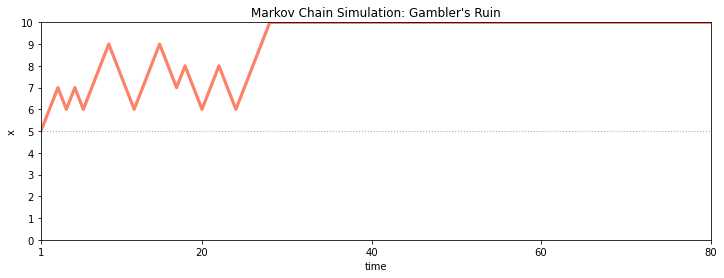

In [10]:
time = np.arange(1, nsim+1)

plt.figure(figsize=(12,4))

plt.plot(time, x, '-', lw=3.2, alpha=0.7, color='#fc4e2a')
plt.hlines(5, 0, nsim, ls='dotted', lw=1.1, alpha=0.5)

plt.ylim((0,10))
plt.ylabel('x')
plt.yticks(range(0,11,1))
plt.xlim(1,nsim)
plt.xlabel('time')
plt.xticks([1, 20, 40, 60, 80])
plt.title('Markov Chain Simulation: Gambler\'s Ruin')

plt.show()

You should see a path that starts at 5 and bounces up and down before being absorbed into state 0 or state N.

## Simulating from a finite-state Markov chain

With a few modifications, we can simulate from an arbitrary Markov chain on a finite state space. For concreteness, we will illustrate how to simulate from the 4-state Markov chain in Example 11.1.5.

As above, we can type

In [11]:
Q = np.array([[1/3, 1/3, 1/3, 0],
              [0, 0, 1/2, 1/2],
              [0, 1, 0, 0],
              [1/2, 0, 0, 1/2]])

to specify the transition matrix $Q$.

Next, we choose the number of states and the number of time periods to simulate, we allocate space for the results of the simulation, and we choose initial conditions for the chain. In this example, `x[0] = numpy.random.choice(range(1,4+1), 1)[0]` says the initial distribution of the chain is uniform over all states. States 1, 2, 3, 4 map to Python matrix row indices 0, 1, 2, 3.

In [12]:
np.random.seed(433494437)

# states: 1, 2, 3, 4
M = Q.shape[0]
nsim = 10**4
x = np.zeros(nsim)
x[0] = np.random.choice(range(1, M+1), 1)[0]

For the simulation itself, we again use `numpy.random.choice` to choose a number from 1 to `M`. At time `i`, the chain was previously at state `x[i-1]`, so we must use row `x[i-1]` of the transition matrix to determine the probabilities of sampling $1, 2, \dots, M$. The notation `Q[x[i-1] - 1, :]` denotes row `x[i-1] - 1` of the matrix $Q$ (but do not forget that with states 1, 2, 3, 4, indexing matrix `Q` needs to use 0, 1, 2, 3 since arrays/matrices in Python are zero-indexed, hence we need to decrement by 1).

In [13]:
np.random.seed(888)

for i in range(1, nsim):
    prev_row = int(x[i-1] - 1)
    x[i] = np.random.choice(range(1,M+1), 1, p=Q[prev_row, :])[0]

Since we set `nsim` to a large number, it may be reasonable to believe that the chain is close to stationarity during the latter portion of the simulation. To check this, we eliminate the first half of the simulations to give the chain time to reach stationarity:

In [14]:
# index of halfway point
halfway = int(nsim/2)

# slice array x keeping the latter half of x
# (starting from the halfway point)
x = x[-halfway:]

We then use [`numpy.unique`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) to calculate the number of times the chain visited each state; dividing by `x.size` converts the counts into proportions. The result is an approximation to the stationary distribution.

In [15]:
_, counts = np.unique(x, return_counts=True)

stat_dist = counts / x.size
print('approximation to stationary distribution of Q:\n{}'.format(stat_dist))

approximation to stationary distribution of Q:
[0.2116 0.2846 0.2156 0.2882]


For comparison, the true stationary distribution of the chain is (3/14, 2/7, 3/14, 2/7) $\approx$ (0.214, 0.286, 0.214, 0.286). Is this close to what you obtained empirically?

----

Joseph K. Blitzstein and Jessica Hwang, Harvard University and Stanford University, &copy; 2019 by Taylor and Francis Group, LLC